# emcee mcmc Introduction
found at http://dfm.io/emcee/current/

## How to Sample a Multi-dimensional Gaussian

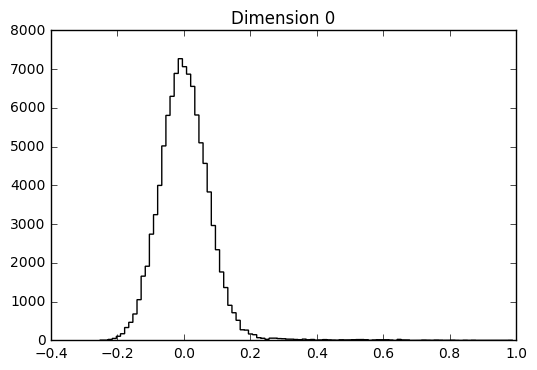

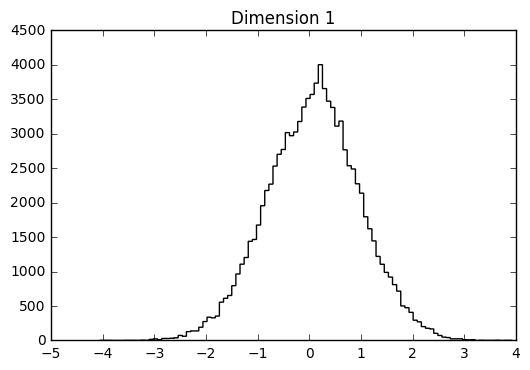

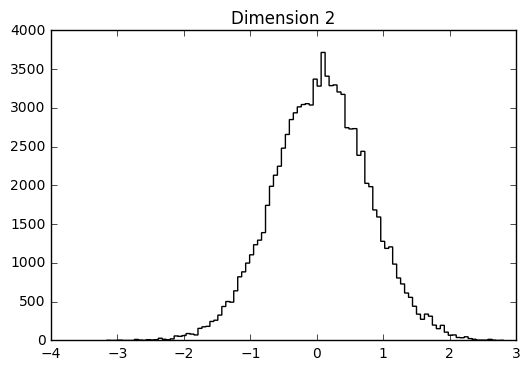

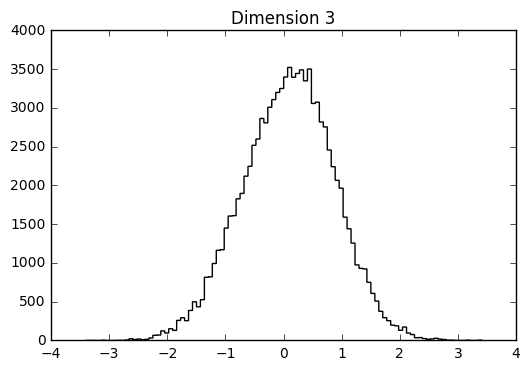

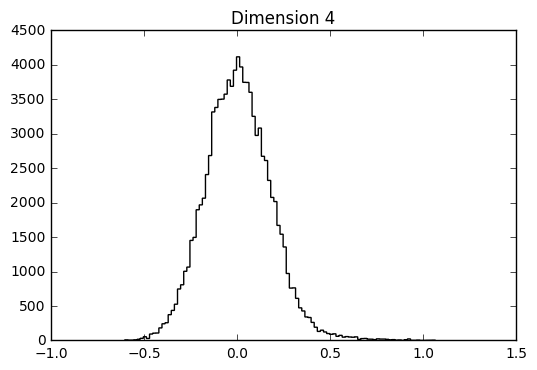

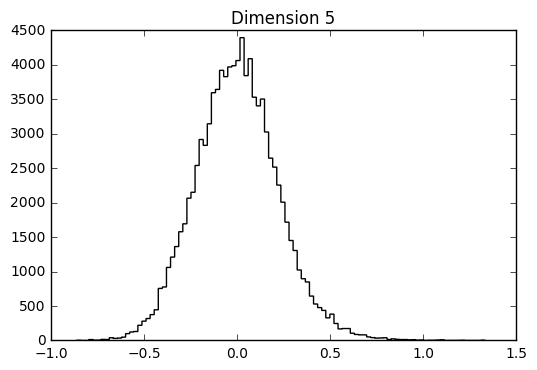

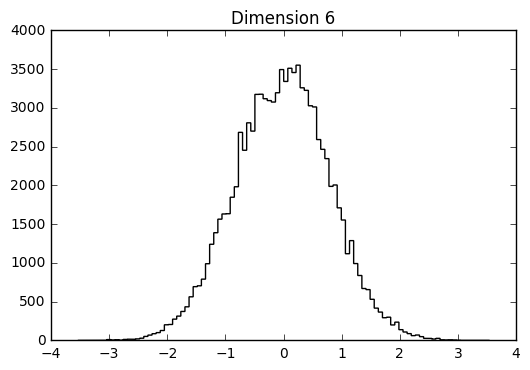

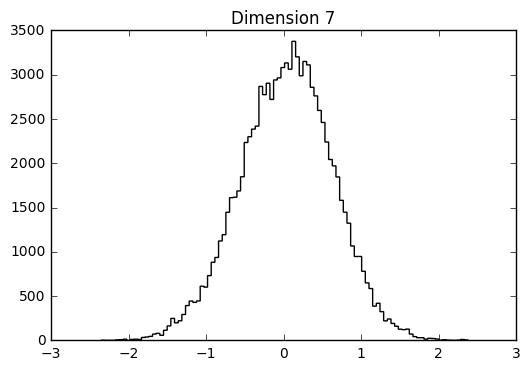

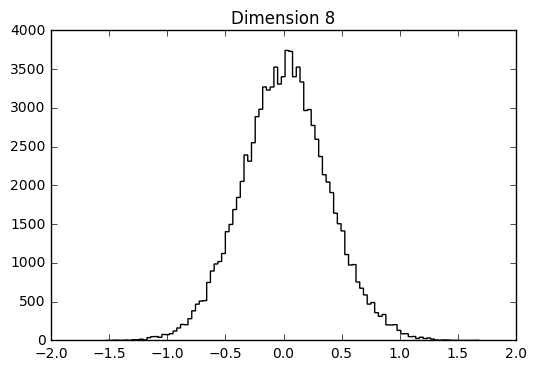

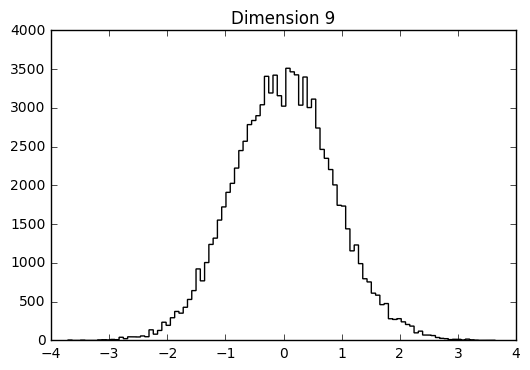

In [1]:
# basic usage example found on homepage
import numpy as np
import emcee
import matplotlib.pyplot as pl

# defines a probability density of the form exp(-1/2 * V*x^2)
def lnprob(x, ivar):
    return -0.5 * np.sum(ivar * x ** 2)

ndim, nwalkers = 10, 100
ivar = 1. / np.random.rand(ndim)
p0 = [np.random.rand(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[ivar])
sampler.run_mcmc(p0, 1000)

# plot results
for i in range(ndim):
    pl.figure()
    pl.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    pl.title("Dimension {0:d}".format(i))

pl.show()

In [2]:
# tutorial at http://dfm.io/emcee/current/user/quickstart/ states that this should be between 0.25 and 0.5. 
# Not certain why.
print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.415


## Fitting a Model to Data
http://dfm.io/emcee/current/user/line/

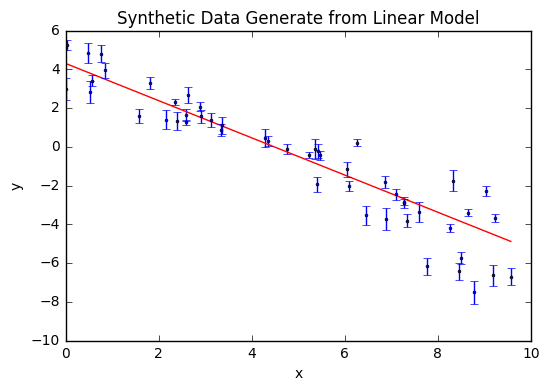

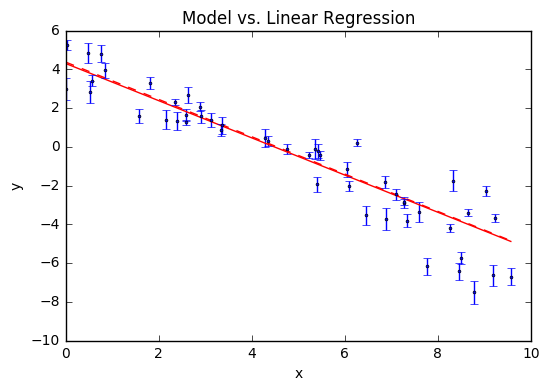

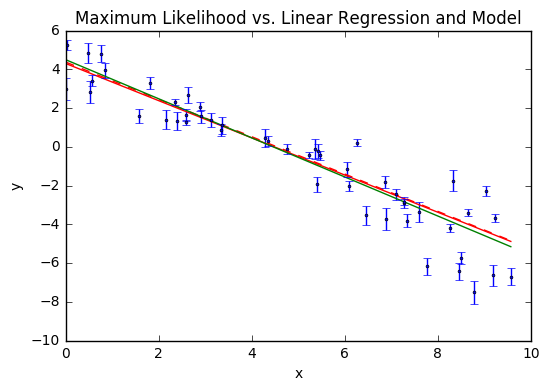

In [3]:
# We're going to generate a synthetic dataset from a given model, and then fit to the data.
# 

# import necessary packages
import numpy as np
import emcee
import matplotlib.pyplot as pl
import scipy.optimize as op
import corner

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

# results from Linear least squares
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))

# results from Maximum Likelihood Estimation
# define (log) likelihood function
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))
# use scipy to maximize
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]

# visualize synthetic data
# plot results of synthetic data
fig, axes = pl.subplots()
axes.plot(x, m_true*x+b_true, 'r')
axes.errorbar(x, y, yerr=yerr, fmt='o', markersize=2)
axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_title('Synthetic Data Generate from Linear Model')
pl.show()

# plot results of least squares regression and compare with model
fig, axes = pl.subplots()
axes.plot(x, m_true*x+b_true, 'r')
axes.plot(x, m_ls*x+b_ls, 'r--')
axes.errorbar(x, y, yerr=yerr, fmt='o', markersize=2)
axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_title('Model vs. Linear Regression')
pl.show()

# plot results of Maximum Likelihood and compare with model and least squares regression
fig, axes = pl.subplots()
axes.plot(x, m_true*x+b_true, 'r')
axes.plot(x, m_ls*x+b_ls, 'r--')
axes.plot(x, m_ml*x+b_ml, 'g')
axes.errorbar(x, y, yerr=yerr, fmt='o', markersize=2)
axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_title('Maximum Likelihood vs. Linear Regression and Model')
pl.show()

In [4]:
[[m_true, b_true, f_true],[m_ls, b_ls, 0],[m_ml, b_ml, lnf_ml]]

[[-0.9594, 4.294, 0.534],
 [-0.96293943774850344, 4.3661583272207984, 0],
 [-1.0081902712855597, 4.4888903082027198, -0.96395928678611098]]

## Marginalization and Uncertainty estimation

In [5]:
# define uniform priors for m, b, and lnf
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf
# define full log-probability function
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

# setup emcee sampling
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
res = sampler.run_mcmc(pos, 500)

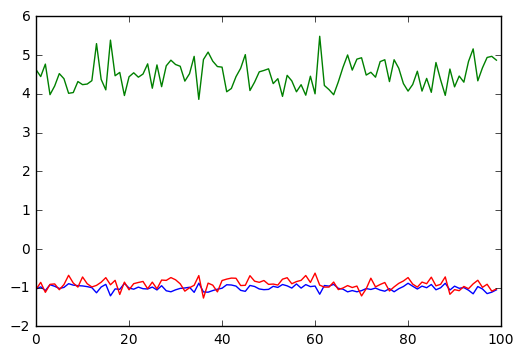

In [6]:
pl.plot(res[0])

pl.show()

In [7]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

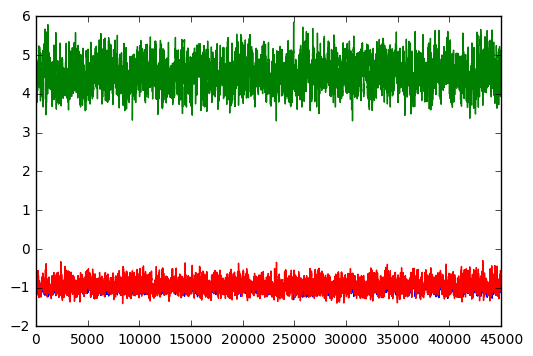

In [8]:
pl.plot(samples)
pl.show()

## Results

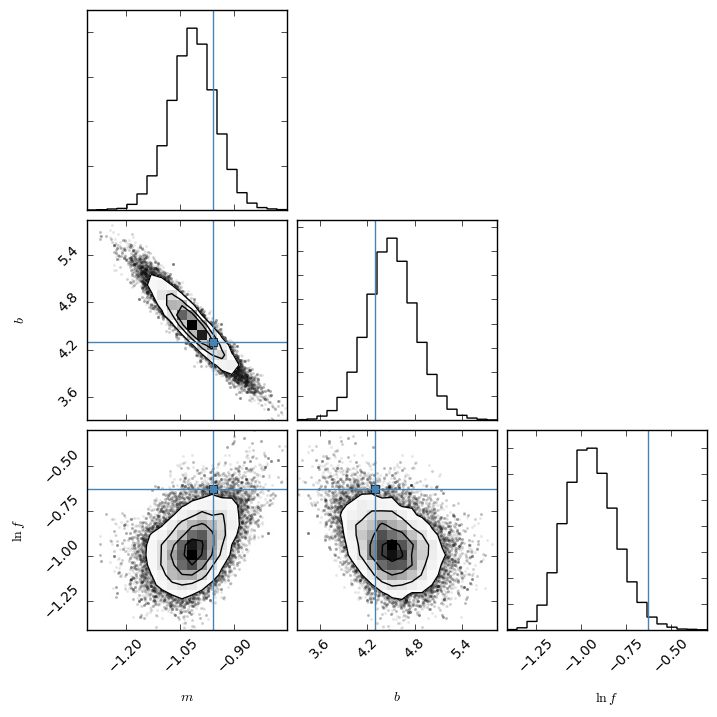

In [9]:
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_true, b_true, np.log(f_true)])
#fig.savefig("triangle.png")
pl.show()

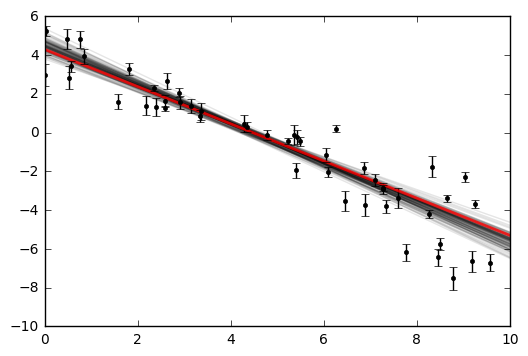

-1.01408065278 4.50634097898 0.387561711405
-0.9594 4.294 0.534


In [10]:
xl = np.array([0, 10])
for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    pl.plot(xl, m*xl+b, color="k", alpha=0.1)
pl.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
pl.errorbar(x, y, yerr=yerr, fmt=".k")
pl.show()

samples[:, 2] = np.exp(samples[:, 2])
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

print(m_mcmc[0], b_mcmc[0], f_mcmc[0])
print(m_true, b_true, f_true)